Model orthogonalization with LDM variants (heavily based on Vojta's original code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good model 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants
        ├── 4 classes, 2 models of each class
        ├── 1 good model 7 bad models
        ├── 4 good models 4 bad models
        ├── 7 good models 1 bad model
        ├── 1 model perfect 7 models bad
        ├── 8 perfect models with a various scales random corruption
        ├── 1 model perfect 8 other models
        ├── 1 good model 1 bad model
        ├── 2 good models 10 bad models
    └── PCA - Analysis
        ├── Raw model output  -  not standardized
        ├── Raw model output  -  standardized
        ├── Residuals - not standardized
        ├── Residuals - standardized
        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#def LDM_extended(params, x):
#    #x = (n,z)
#    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
#    
#    n=x[0]
#    z=x[1]
#    A = n + z
#    I = (n-z)/(n+z)
#    #I = 0
#
#    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)

def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

### Global variables####

# SkO values selected for the truth
#truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]
corruption_noise_Mass=1/3*0

c1_params = [SLY_params, NL1_params]
c2_params = [[-15.972, 18.4, 9, 32.01, -54, 0, 0.57], [-16.425, 18.8, 9, 43.48, -110, 0, 0.57]]
c3_params = [[-15.972, 18.4, 9, 32.01, 0, 0, 0.57], [-16.425, 18.8, 9, 43.48, 0, 0, 0.57]]
c4_params = [[-15.972, 18.4, 9, 0, 0, 0, 0.57], [-16.425, 18.8, 9, 0, 0, 0, 0.57]]


noise_term=0.001

##########################

## Version 2.0 - LDM variants

### Scenario - 1 good model 1 bad model

In [2]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g1b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

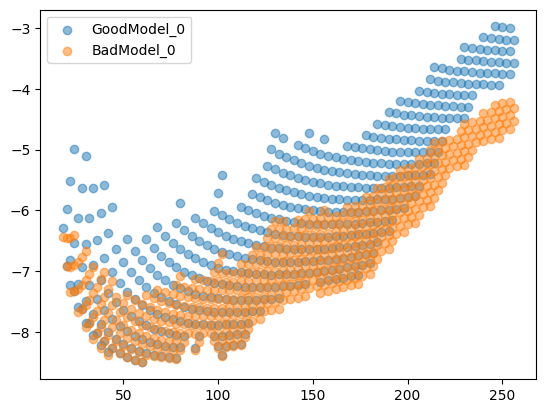

In [3]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.144931  1.333014 -0.124178  0.059382  0.137646
BadModel_0  -6.737253  1.034223  0.468144  0.362202  0.591903
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.14 & 1.33 & -0.12 & 0.06 & 0.14 \\
BadModel_0 & -6.74 & 1.03 & 0.47 & 0.36 & 0.59 \\
\end{tabular}



### Scenario - 1 good model 1 bad models (noise)

In [6]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g1bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)+str("_noise")] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)+str("_noise")] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

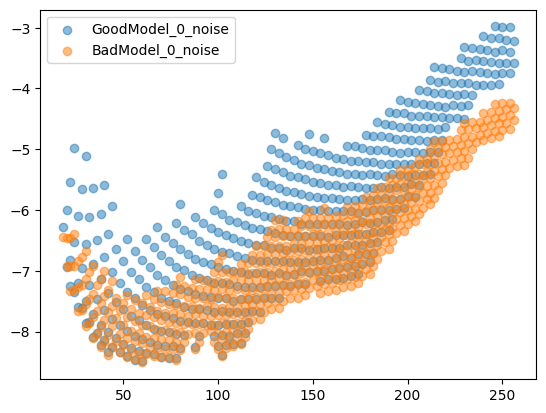

In [7]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                       mean       std  res_mean  res_std      rmse
GoodModel_0_noise -6.145730  1.332457 -0.123378  0.05987  0.137137
BadModel_0_noise  -6.737361  1.035134  0.468252  0.36148  0.591547
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0_noise & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
BadModel_0_noise & -6.74 & 1.04 & 0.47 & 0.36 & 0.59 \\
\end{tabular}



### Scenario - 3 good model 10 bad models

In [26]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

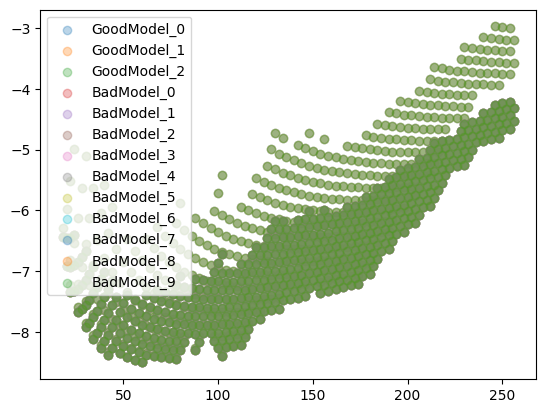

In [27]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [28]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.144931  1.333014 -0.124178  0.059382  0.137646
GoodModel_1 -6.144931  1.333014 -0.124178  0.059382  0.137646
GoodModel_2 -6.144931  1.333014 -0.124178  0.059382  0.137646
BadModel_0  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_1  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_2  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_3  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_4  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_5  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_6  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_7  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_8  -6.737253  1.034223  0.468144  0.362202  0.591903
BadModel_9  -6.737253  1.034223  0.468144  0.362202  0.591903
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.14 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

### Scenario - 3 good model 10 bad models (noise)

In [3]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "3g10bNoise"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 3
models_output = {}
params = c1_params
# models = ["SLy4", "NL1"]

for i in range(n_class_1):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term


n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

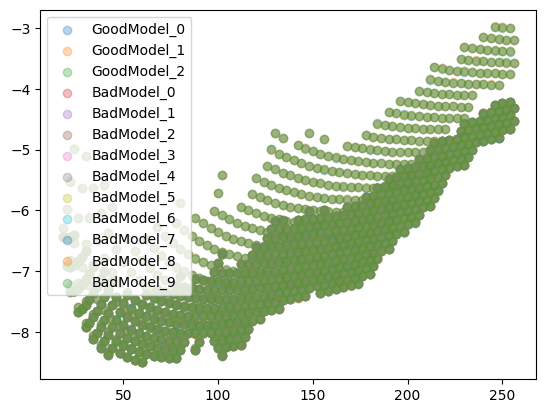

In [4]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [5]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_predictions=models_output_df[models_output.keys()].values

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                 mean       std  res_mean   res_std      rmse
GoodModel_0 -6.145011  1.332955 -0.124098  0.059359  0.137564
GoodModel_1 -6.144941  1.333104 -0.124167  0.059364  0.137628
GoodModel_2 -6.144898  1.333020 -0.124211  0.059391  0.137680
BadModel_0  -6.737298  1.034249  0.468189  0.362164  0.591915
BadModel_1  -6.737343  1.034290  0.468234  0.362152  0.591944
BadModel_2  -6.737276  1.034290  0.468167  0.362160  0.591896
BadModel_3  -6.737292  1.034247  0.468183  0.362220  0.591945
BadModel_4  -6.737254  1.034259  0.468145  0.362164  0.591881
BadModel_5  -6.737248  1.034194  0.468139  0.362244  0.591925
BadModel_6  -6.737267  1.034216  0.468159  0.362229  0.591931
BadModel_7  -6.737221  1.034237  0.468113  0.362187  0.591869
BadModel_8  -6.737264  1.034244  0.468155  0.362147  0.591878
BadModel_9  -6.737323  1.034236  0.468214  0.362189  0.591951
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
GoodModel_0 & -6.15 & 1.33 & -0.12 & 0.06 & 0.14 \\
GoodModel_1

## PCA - Analysis

### Option 1: Not centering and not using residuals, but rather the full model predictions

In [34]:
np.shape(residuals)

(521, 13)

In [6]:
U, S, Vt = np.linalg.svd(model_predictions)

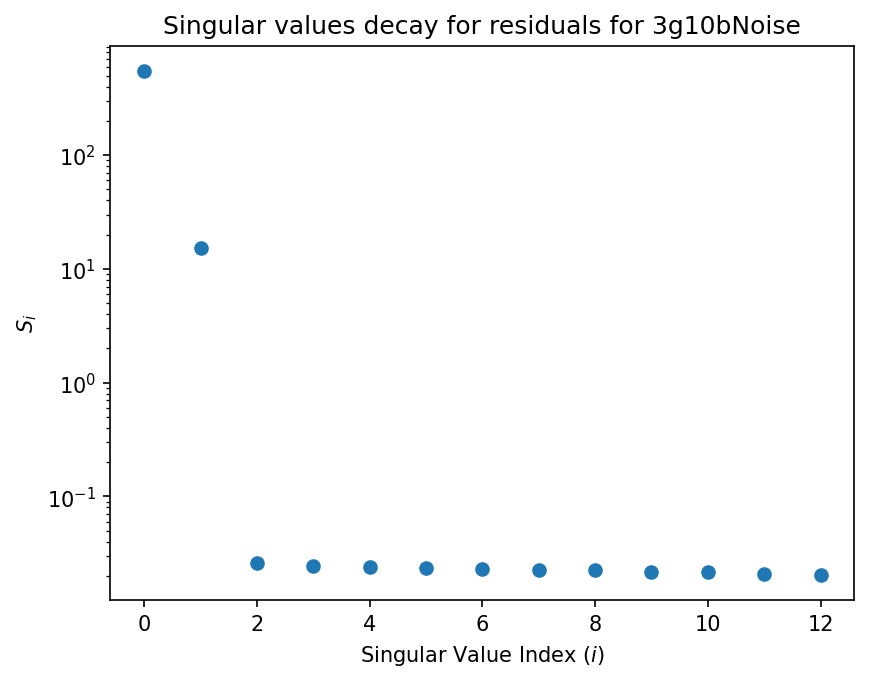

In [7]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');
plt.title("Singular values decay for residuals for " +scenario)
plt.show()

In [9]:
components_kept=2
U_hat=np.array([U.T[i] for i in range(components_kept)]).T
S_hat=np.array([S[i] for i in range(components_kept)])
Vt_hat=np.array([Vt[i] for i in range(components_kept)])


In [12]:
np.shape(U_hat[0])

(2,)

In [48]:
Vt_hat

array([[ 0.26007379,  0.26007196,  0.26006962,  0.28232828,  0.28233039,
         0.28232765,  0.282328  ,  0.28232655,  0.28232584,  0.2823268 ,
         0.28232507,  0.28232689,  0.28232922],
       [ 0.51535142,  0.51556678,  0.515453  , -0.14242487, -0.14240538,
        -0.14241264, -0.14249383, -0.14241969, -0.14252178, -0.14249953,
        -0.14244482, -0.14238994, -0.14245934]])

In [60]:
len(residuals[0])

13

In [61]:
len(residuals[0])

13

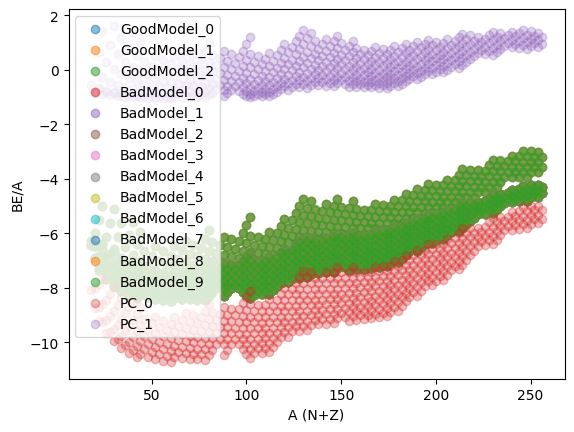

In [56]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)






for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = 0.35*U_hat.T[0]*(S_hat[0]), label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1]*(S_hat[1]), label = str("PC_") + str(1), alpha = 0.3)
plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [57]:

results_min=np.linalg.lstsq(U_hat, masses_truth.values[:,None], rcond=None)[0]


In [31]:
results_min

array([[146.27020552],
       [ -4.8634556 ]])

In [58]:
results_min

array([[146.16140078],
       [  7.44796359]])

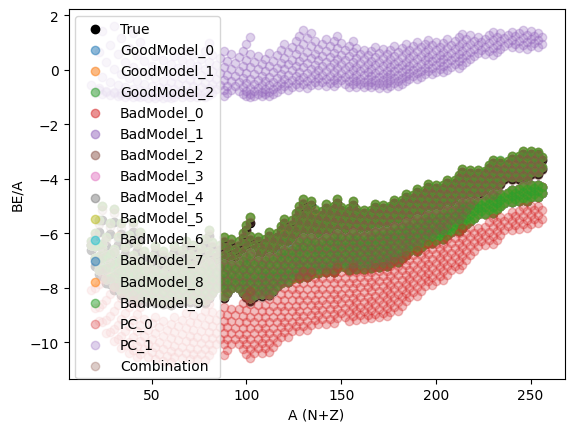

In [60]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = masses_truth.values[:,None], label = str("True"), color='k')



for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# 


# for i in range(components_kept):
plt.scatter(x = models_output_df["A"], y = 0.35*U_hat.T[0]*(S_hat[0]), label = str("PC_") + str(0), alpha = 0.3)
plt.scatter(x = models_output_df["A"], y = U_hat.T[1]*(S_hat[1]), label = str("PC_") + str(1), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = U_hat.T[0]*results_min[0]+U_hat.T[1]*results_min[1], label = str("Combination"), alpha = 0.3)

plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [66]:
models_output_df['GoodModel_0'].values 


array([-6.29106731, -5.98399802, -5.52521723, -4.98341697, -6.92318891,
       -6.82292326, -6.53180376, -6.11842621, -5.63531982, -5.10322847,
       -7.23069943, -7.32808973, -7.20317748, -6.93387888, -6.5595217 ,
       -6.11891911, -5.63727163, -7.58892386, -7.62159349, -7.48840533,
       -7.23311872, -6.89027866, -6.49117656, -6.05128184, -5.58420724,
       -7.85533091, -7.84615988, -7.70567363, -7.46330298, -7.14722085,
       -6.77946859, -6.37665232, -5.94209784, -8.05954163, -8.01985764,
       -7.87538783, -7.64466116, -7.35117478, -7.01059734, -6.63418827,
       -8.21357469, -8.15390653, -8.00706625, -7.78760384, -7.5109206 ,
       -7.19378278, -6.84270191, -6.46844099, -8.33473172, -8.26163693,
       -8.11088249, -7.89862477, -7.63876165, -7.34077897, -7.01257187,
       -6.66137164, -8.34416288, -8.19526714, -7.99069152, -7.74241545,
       -7.45941511, -7.14872074, -6.8180159 , -6.47108294, -8.41060774,
       -8.26055339, -8.06281626, -7.82444136, -7.55737596, -7.26

In [69]:
masses_truth.values[:,None]

array([[-6.59565677],
       [-6.3258904 ],
       [-5.93996007],
       [-5.49992341],
       [-7.1901886 ],
       [-7.0908561 ],
       [-6.82284545],
       [-6.45426271],
       [-6.03068886],
       [-5.58112237],
       [-7.49770264],
       [-7.57009002],
       [-7.44651164],
       [-7.18848545],
       [-6.84361974],
       [-6.44590769],
       [-6.0187056 ],
       [-7.83132228],
       [-7.84779721],
       [-7.71089579],
       [-7.46424691],
       [-7.14241917],
       [-6.77127178],
       [-6.36957428],
       [-5.95069779],
       [-8.07778175],
       [-8.05661837],
       [-7.9120962 ],
       [-7.67623852],
       [-7.37494545],
       [-7.02828253],
       [-6.65142276],
       [-6.25566311],
       [-8.26399021],
       [-8.2165157 ],
       [-8.06760135],
       [-7.84144463],
       [-7.55796363],
       [-7.23301645],
       [-6.87898028],
       [-8.40668771],
       [-8.34027003],
       [-8.18890254],
       [-7.97132217],
       [-7.70318603],
       [-7

In [68]:
np.linalg.norm(models_output_df['GoodModel_0'].values -masses_truth.values[:,None])/len(models_output_df['GoodModel_0'].values)

1.897506557674897

In [71]:
np.linalg.norm((U_hat.T[0]*results_min[0]+U_hat.T[1]*results_min[1]) -masses_truth.values[:,None])/len(models_output_df['GoodModel_0'].values)

1.8958049044203777

In [11]:
def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



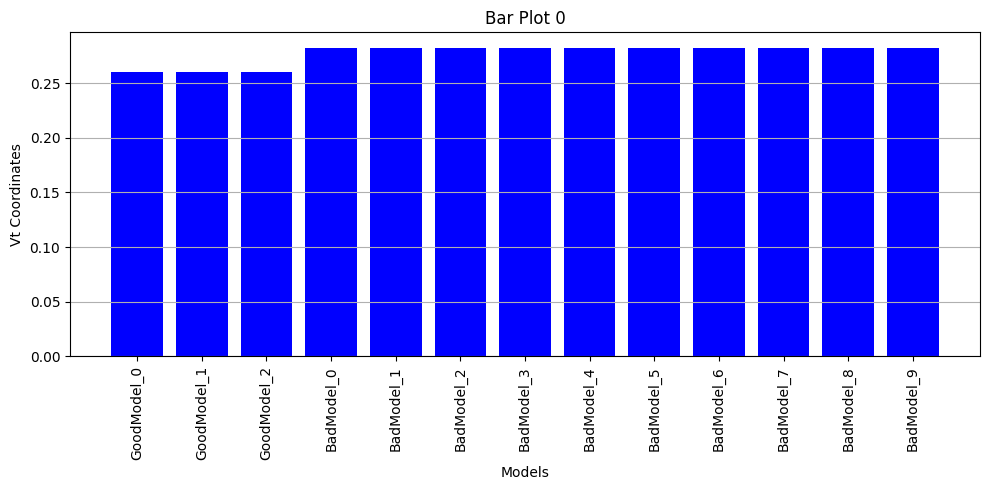

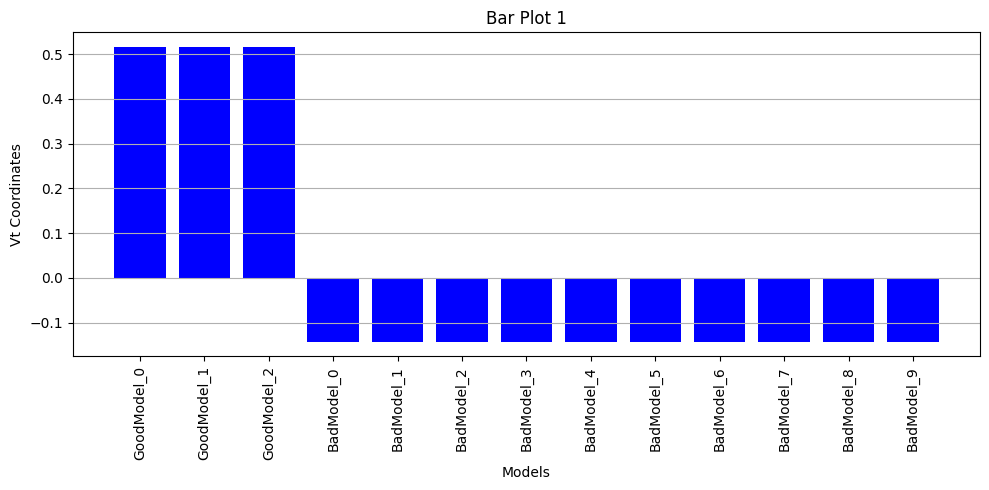

In [12]:
labels_list = list(models_output.keys())

for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], labels_list, title=f"Bar Plot {i}", color='blue')

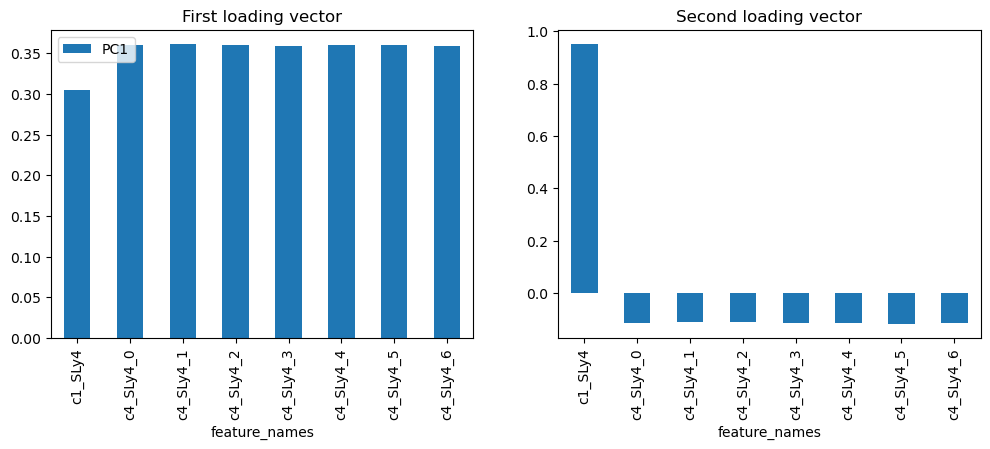

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.304615  0.952458  0.001646  0.003031
c4_SLy4_0      0.359904 -0.114211 -0.450550 -0.025725
c4_SLy4_1      0.360969 -0.112959 -0.333089 -0.565300
c4_SLy4_2      0.360086 -0.111761  0.387221 -0.280461
c4_SLy4_3      0.359327 -0.115066 -0.374499  0.701553
c4_SLy4_4      0.360033 -0.116166  0.358065  0.019871
c4_SLy4_5      0.360268 -0.118604  0.508130  0.295528
c4_SLy4_6      0.359423 -0.117163 -0.097253 -0.145593


In [24]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

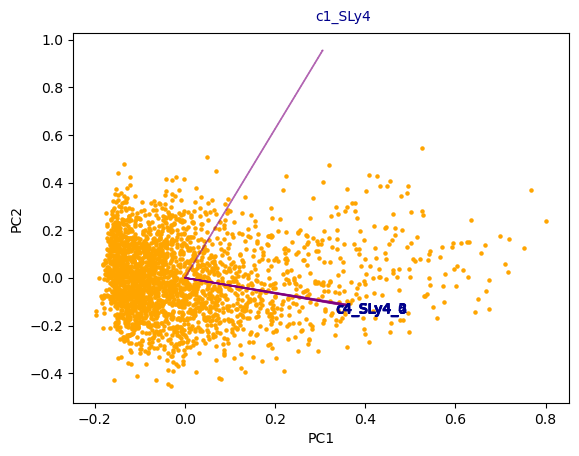

In [25]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Raw model output -  standardized

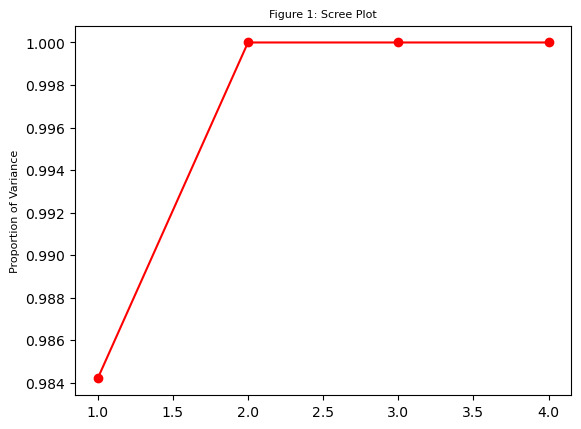

In [14]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

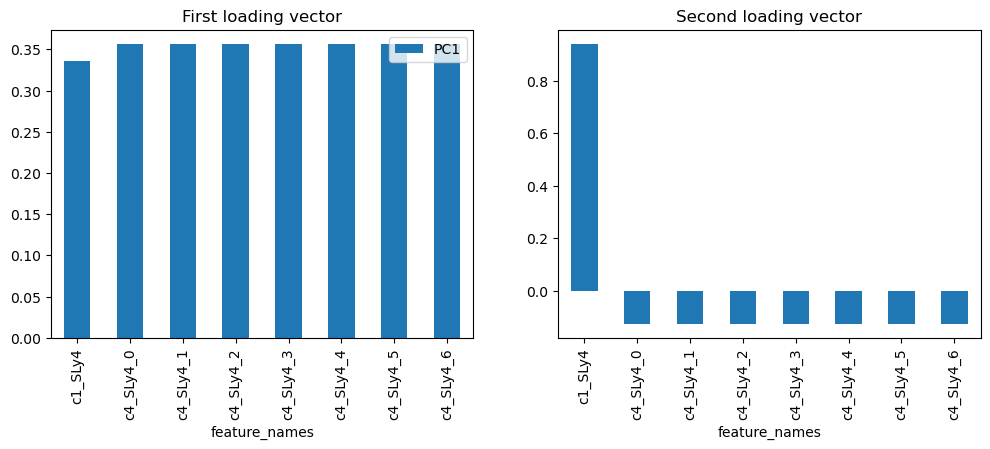

                    PC1       PC2       PC3           PC4
feature_names                                            
c1_SLy4        0.335808  0.941931 -0.000000  0.000000e+00
c4_SLy4_0      0.356016 -0.126923 -0.925820 -1.941078e-16
c4_SLy4_1      0.356016 -0.126923  0.154303  9.128709e-01
c4_SLy4_2      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_3      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_4      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_5      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_6      0.356016 -0.126923  0.154303 -1.825742e-01


In [15]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

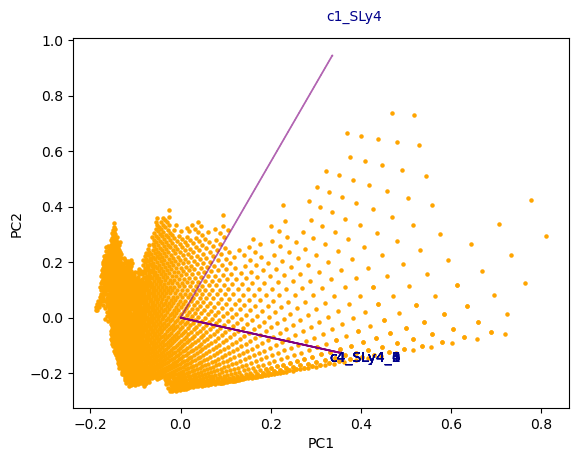

In [16]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Residuals - not standardized

In [324]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ,

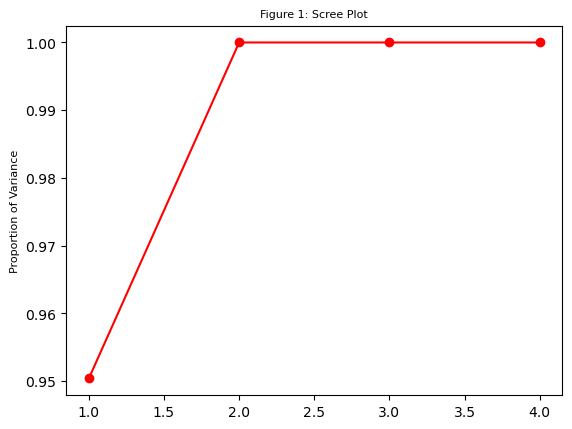

In [325]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

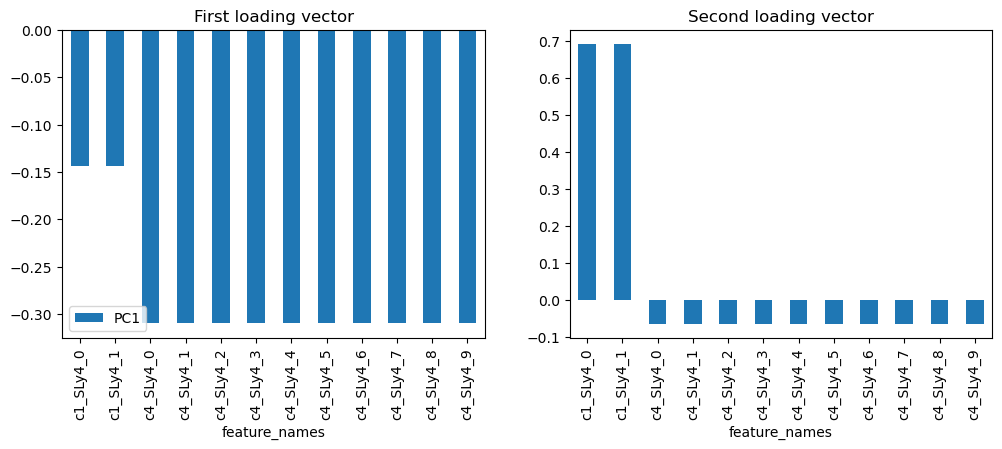

                    PC1       PC2           PC3           PC4
feature_names                                                
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_9     -0.309651 -0.064158  4.736177e-17  1.054093e-01


In [326]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

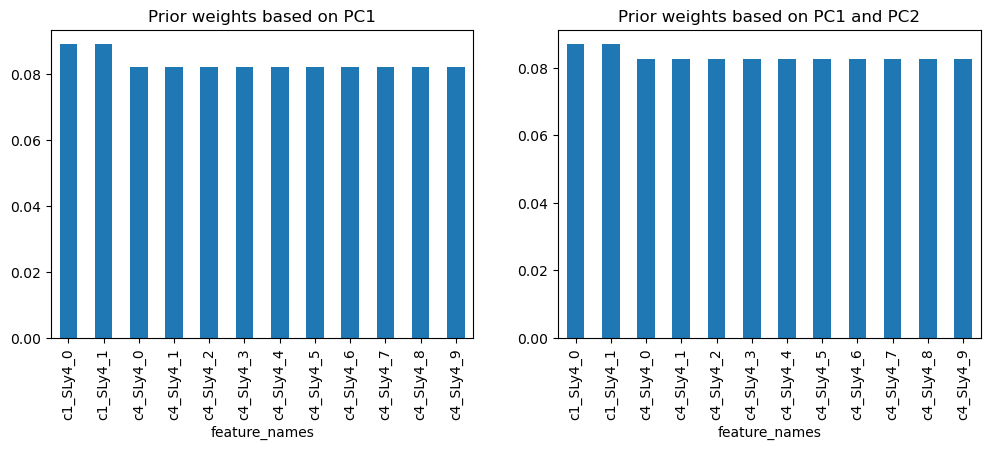

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00  0.089038   
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17  0.089038   
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01  0.082192   
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_9     -0.309651 -

In [327]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV1_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

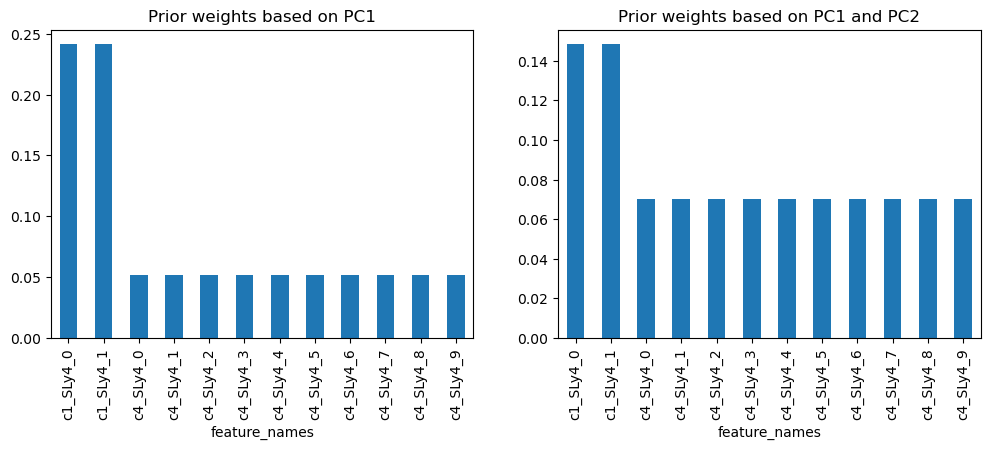

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00  0.241169   
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17  0.241169   
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01  0.051766   
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_9     -0.309651 -

In [328]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV2_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

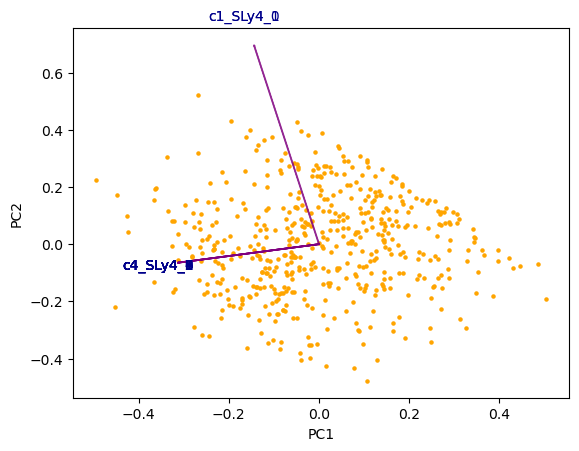

In [329]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

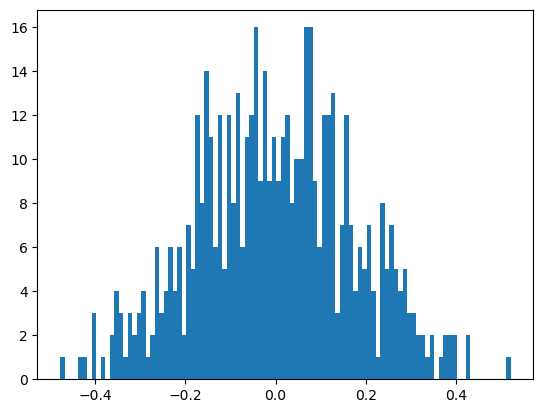

-0.47828529225015803


In [330]:
PCA_2_scaled = X_pca[:,1] / (X_pca[:,1].max() - X_pca[:,1].min())
plt.hist(PCA_2_scaled, bins = 100)
plt.show()
print(PCA_2_scaled.min())

### Residuals - standardized

In [54]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ,

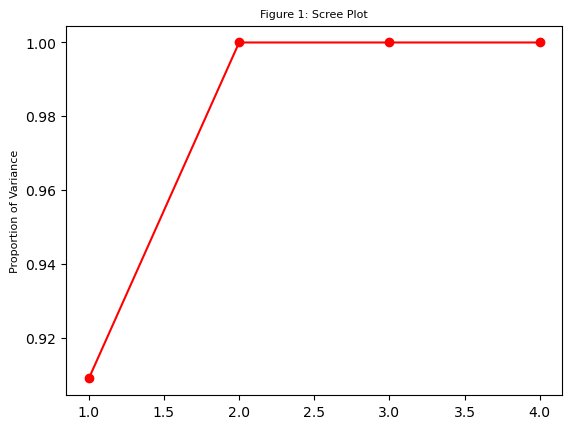

In [55]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

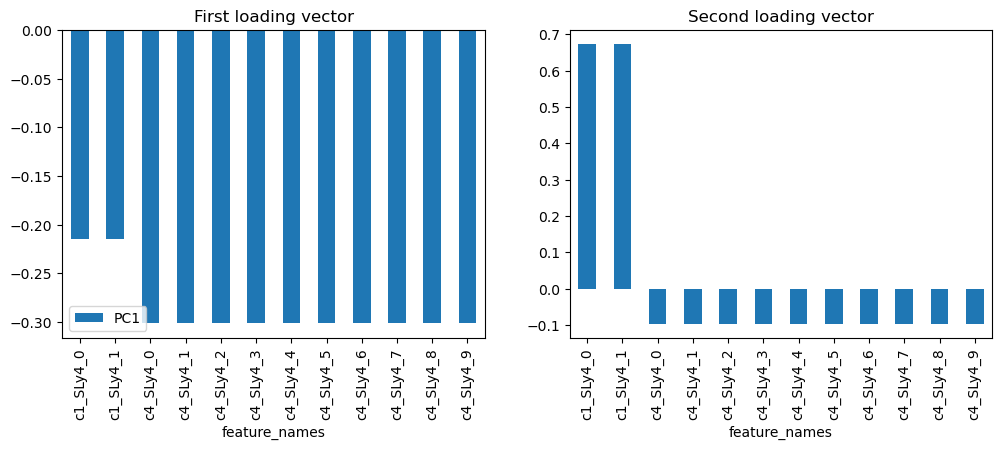

                    PC1       PC2           PC3           PC4
feature_names                                                
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_9     -0.301245 -0.096184 -6.896201e-17  1.054093e-01


In [56]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

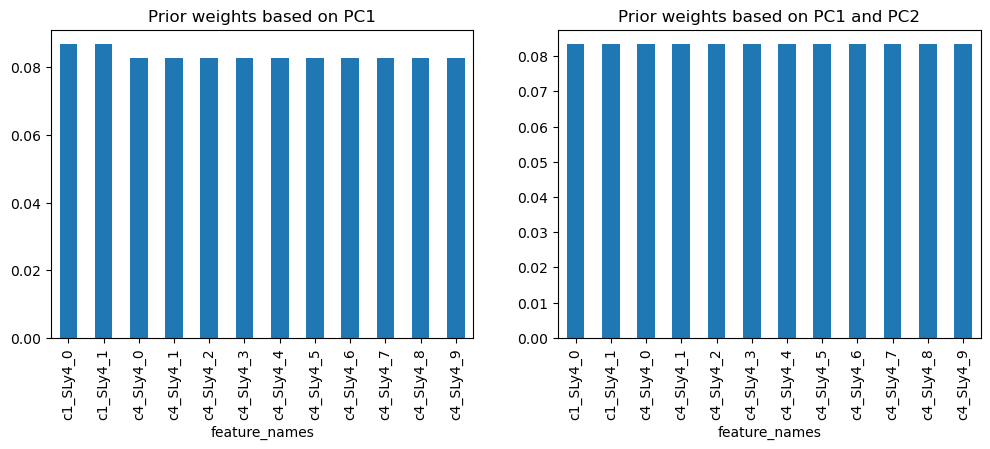

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00  0.086704   
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16  0.086704   
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01  0.082659   
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_9     -0.301245 -

In [57]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV1.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

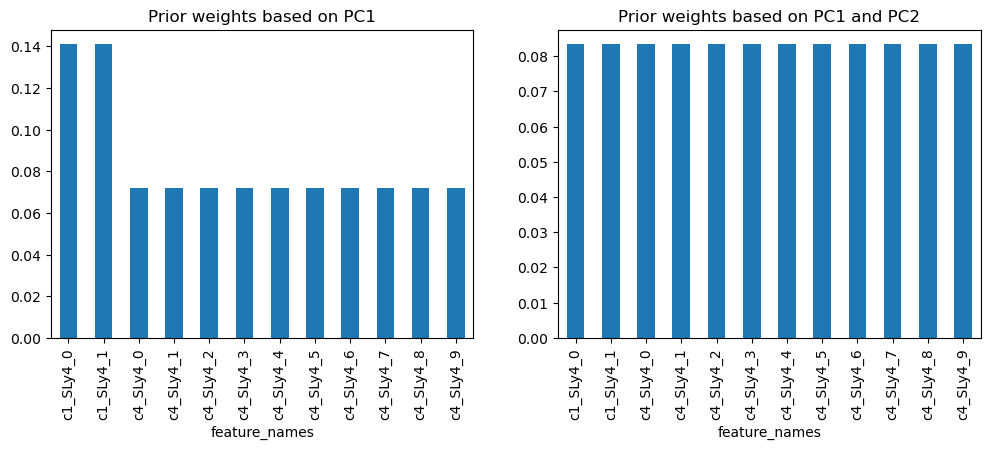

                    PC1       PC2           PC3           PC4      PW1  \
feature_names                                                            
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00  0.14090   
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16  0.14090   
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01  0.07182   
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_9     -0.301245 -0.096184 -6.8

In [58]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV2.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

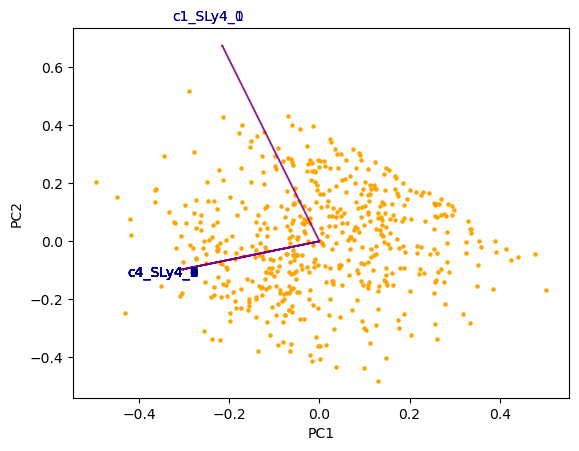

In [59]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()